<a href="https://colab.research.google.com/github/marcinwolter/MachineLearnin2019/blob/master/MDN_1D_sine_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixture Density Network

Reproducing the classic Bishop MDN network tasks in Keras. The idea in this task is to predict a the value of an inverse sine function. This function has multiple real-valued solutions at each point, so the ANN model needs to have the capacity to handle this in it's loss function. An MDN is a good way to handle the predictions of these multiple output values.

There's a couple of other versions of this task, and this implementation owes much to the following:

- [David Ha - Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- [Mixture Density Networks in Edward](http://edwardlib.org/tutorials/mixture-density-network)

In [56]:
#!pip install git+git://github.com/cpmpercussion/keras-mdn-layer.git#egg=keras-mdn-layer
!pip install keras-mdn-layer
###!python3 -m pip install keras-mdn-layer

from tensorflow.compat.v1 import keras
###import keras
import mdn
#from context import * # imports the MDN layer 
import numpy as np
import random
import matplotlib.pyplot as plt
#%matplotlib notebook

## Generate Synthetic Data

Data generation

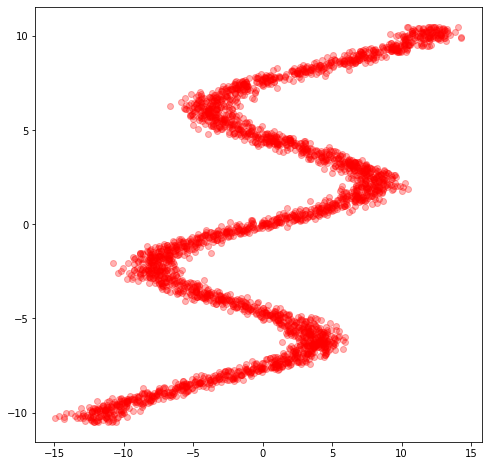

In [57]:
## Generating some data:
NSAMPLE = 3000

y_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
x_data = x_data.reshape((NSAMPLE, 1))

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

## Build the MDN Model

Now we will construct the MDN model in Keras. This uses the `Sequential` model interface in Keras.

The `MDN` layer comes after one or more `Dense` layers. You need to define the output dimension and number of mixtures for the MDN like so: `MDN(output_dimension, number_mixtures)`.

For this problem, we only need an output dimension of 1 as we are predicting one value (y). Adding more mixtures adds a more parameters (model is more complex, takes longer to train), but might help make the solutions better. You can see from the training data that there are at maximum 5 different layers to predict in the curve, so setting `N_MIXES = 5` is a good place to start.

For MDNs, we have to use a special loss function that can handle the mixture parameters: the function has to take into account the number of output dimensions and mixtures.

In [58]:
N_HIDDEN = 15
N_MIXES = 10  #5

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model.add(mdn.MDN(1, N_MIXES))

model.compile(loss=mdn.get_mixture_loss_func(1,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 15)                30        
_________________________________________________________________
dense_11 (Dense)             (None, 15)                240       
_________________________________________________________________
mdn_5 (MDN)                  (None, 30)                480       
Total params: 750
Trainable params: 750
Non-trainable params: 0
_________________________________________________________________


### Training the model

Now we train the model using Keras' normal `fit` command.

In [59]:
history = model.fit(x=x_data, y=y_data, batch_size=128, epochs=500, validation_split=0.15)

Train on 2550 samples, validate on 450 samples
Epoch 1/500
2550/2550 [==============================] - 2s 778us/sample - loss: 7.6923 - val_loss: 7.1178
Epoch 2/500
2550/2550 [==============================] - 0s 82us/sample - loss: 6.3383 - val_loss: 5.8924
Epoch 3/500
2550/2550 [==============================] - 0s 78us/sample - loss: 5.2579 - val_loss: 4.9901
Epoch 4/500
2550/2550 [==============================] - 0s 73us/sample - loss: 4.5466 - val_loss: 4.4601
Epoch 5/500
2550/2550 [==============================] - 0s 71us/sample - loss: 4.1442 - val_loss: 4.1470
Epoch 6/500
2550/2550 [==============================] - 0s 69us/sample - loss: 3.9046 - val_loss: 3.9411
Epoch 7/500
2550/2550 [==============================] - 0s 78us/sample - loss: 3.7463 - val_loss: 3.7949
Epoch 8/500
2550/2550 [==============================] - 0s 75us/sample - loss: 3.6304 - val_loss: 3.6738
Epoch 9/500
2550/2550 [==============================] - 0s 73us/sample - loss: 3.5300 - val_loss: 3.545

In [0]:
# Save model if you want to.
# model.save("MDN-1D-sine-prediction-model.h5")

In [0]:
# Load the model if you want to.
# To load models from file, you need to supply the layer and loss function as custom_objects:
# model = keras.models.load_model('MDN-1D-sine-prediction-model.h5', custom_objects={'MDN': mdn.MDN, 'loss_func': mdn.get_mixture_loss_func(1, N_MIXES)})

### Training and Validation Loss

It's interesting to see how the model trained. We can see that after a certain point training is rather slow.

For this problem a loss value around 1.5 produces quite good results.

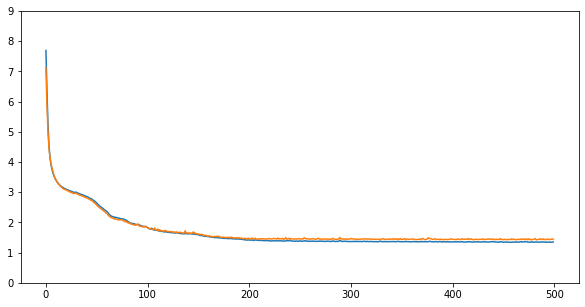

In [62]:
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## Sampling Functions

The MDN model outputs parameters of a mixture model---a list of means (mu), variances (sigma), and weights (pi).

The `mdn` module provides a function to sample from these parameters as follows. First the parameters are split up into `mu`s, `sigma`s and `pi`s, then the categorical distribution formed by the `pi`s is sampled to choose which mixture component should be sampled, then that component's `mu`s and `sigma`s is used to sample from a multivariate normal model, here's the code:

    def sample_from_output(params, output_dim, num_mixes, temp=1.0):
        """Sample from an MDN output with temperature adjustment."""
        mus = params[:num_mixes*output_dim]
        sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
        pis = softmax(params[-num_mixes:], t=temp)
        m = sample_from_categorical(pis)
        # Alternative way to sample from categorical:
        # m = np.random.choice(range(len(pis)), p=pis)
        mus_vector = mus[m*output_dim:(m+1)*output_dim]
        sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
        cov_matrix = np.identity(output_dim) * sig_vector
        sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
        return sample
        
If you only have one prediction to sample from, you can use the function as is; but if you need to sample from a lot of predictions at once (as in the following sections), you can use `np.apply_along_axis` to apply it to a whole numpy array of predicted parameters.

## Try out the MDN Model

Now we try out the model by making predictions at 3000 evenly spaced points on the x-axis. 

Mixture models output lists of parameters, so we're going to sample from these parameters for each point on the x-axis, and also try plotting the parameters themselves so we can have some insight into what the model is learning!

In [63]:
## Sample on some test data:
x_test = np.float32(np.arange(-15,15,0.01))
NTEST = x_test.size
print("Testing:", NTEST, "samples.")
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

# Make predictions from the model
y_test = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Sample from the predicted distributions
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test, 1, N_MIXES,temp=1.0)

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES]),1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES:2*N_MIXES]),1, y_test)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[2*N_MIXES:])),1, y_test)

Testing: 3000 samples.


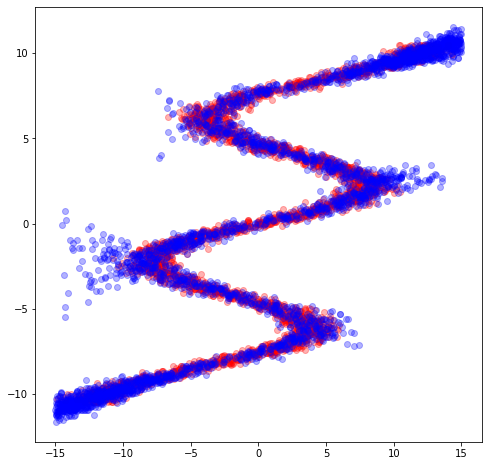

In [64]:
# Plot the samples
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, y_samples[:,:,0], 'bo',alpha=0.3)
plt.show()
# These look pretty good!

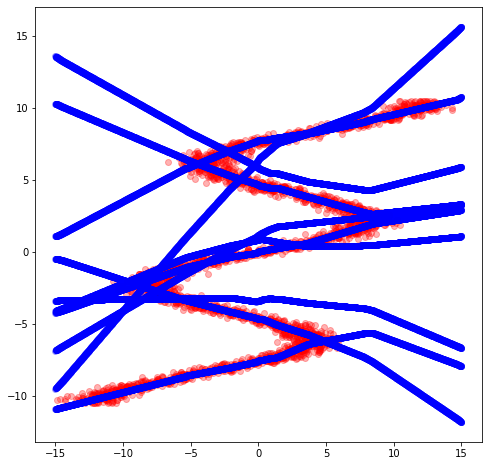

In [65]:
# Plot the means - this gives us some insight into how the model learns to produce the mixtures.
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, mus,'bo',alpha=0.3)
plt.show()
# Cool!

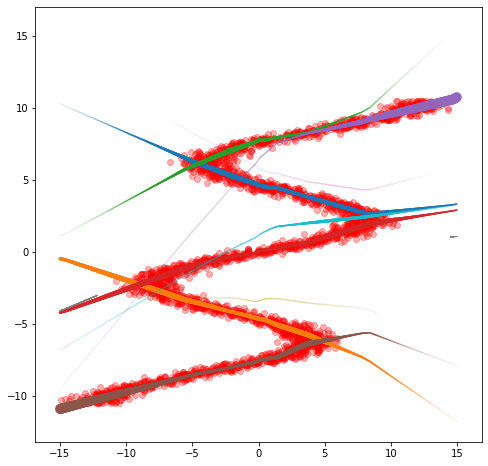

In [66]:
# Let's plot the variances and weightings of the means as well.
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
# ax1.scatter(data[0], data[1], marker='o', c='b', s=data[2], label='the data')
ax1.scatter(x_data,y_data,marker='o', c='r', alpha=0.3)
for i in range(N_MIXES):
    ax1.scatter(x_test, mus[:,i], marker='o', s=200*sigs[:,i]*pis[:,i],alpha=0.3)
plt.show()